# Import Dataset from Kaggle

Configure Kaggle credential before download the dataset

In [1]:
import os
import yaml
import matplotlib.pyplot as plt
import cv2

import shutil
import torch
import torch.nn as nn
from ultralytics import YOLO
import kagglehub

# Download latest version
DATASET = kagglehub.dataset_download("budikawira/container-cnr-letter-detection")

print("Path to dataset files:", DATASET)

100%|███████████████████████████████████████████████████████████████████████████████| 929k/929k [00:00<00:00, 2.05MB/s]

Extracting files...


Path to dataset files: C:\Users\budik\.cache\kagglehub\datasets\budikawira\container-cnr-letter-detection\versions\1


# Dataset EDA

In [2]:
from pathlib import Path
import pandas as pd
from collections import Counter

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
labels_path = Path(DATASET + '/train/labels')
class_counter = Counter()

for txt_file in labels_path.glob('*.txt'):
    try:
        content = txt_file.read_text().splitlines()
        for line in content:
            class_id = int(line.split()[0])
            class_counter[class_id] += 1
    except Exception as e:
        print(f"Error reading {txt_file.name}: {e}")

# Create DataFrame
df = pd.DataFrame([(cls, count) for cls, count in class_counter.items()],
                 columns=['ClassId', 'Instances']).sort_values('ClassId')
df['Class'] = df['ClassId'].apply(lambda x: class_names[x])
df.sort_index()
print(df)

    ClassId  Instances Class
2         0         59     0
8         1         83     1
13        2        117     2
14        3         43     3
4         4         60     4
0         5         42     5
10        6         41     6
15        7         39     7
3         8         28     8
1         9         30     9
30       10          9     A
19       11          9     B
21       12         36     C
18       13         18     D
29       14         20     E
22       15          7     F
9        16         62     G
6        17         15     H
17       18         17     I
34       19          5     J
25       20         16     K
20       21         22     L
16       22         21     M
12       23         14     N
28       24          1     O
27       25          3     P
23       26         17     R
7        27         27     S
11       28         29     T
5        29        109     U
33       30          3     V
26       31          1     W
24       32          7     X
31       33   

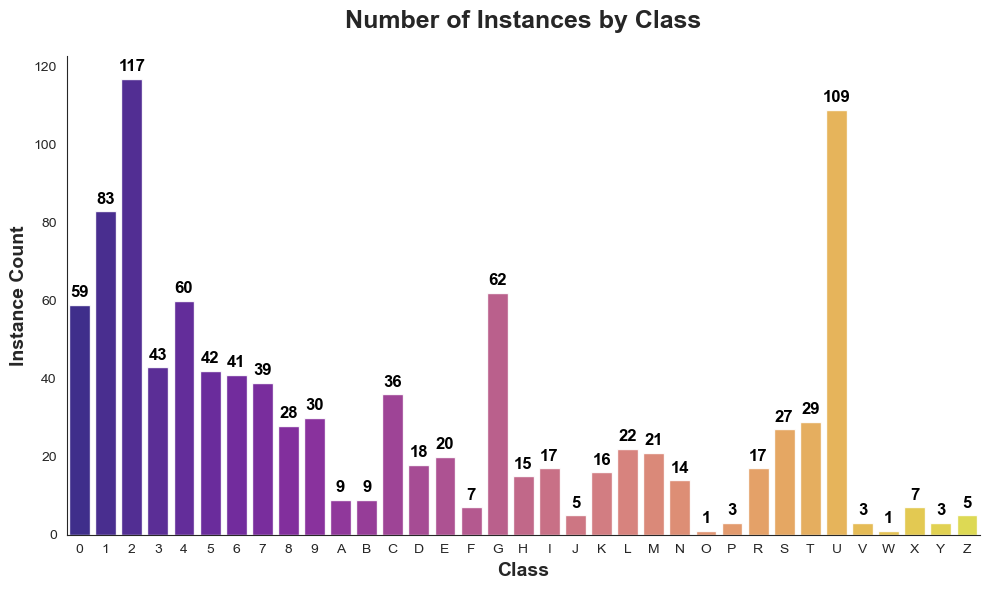

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")
plt.figure(figsize=(10, 6))

# Use `hue` to assign palette per class
ax = sns.barplot(
    data=df,
    x='Class',
    y='Instances',
    hue='Class',           # ← Assign hue to enable palette
    palette='plasma',
    legend=False,          # ← Hide legend (we don't need it for simple bar plots)
    alpha=0.9
)

# Customize labels and title
plt.title('Number of Instances by Class', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14, fontweight='semibold')
plt.ylabel('Instance Count', fontsize=14, fontweight='semibold')

# Add value labels on bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + max(df['Instances']) * 0.01,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Remove borders
sns.despine()

# Layout
plt.tight_layout()
plt.show()

# Model Training

In [4]:
def print_trainable_layers(model):
    print("Trainable layers:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f" - {name}")

def print_frozen_layers(model):
    print("Frozen layers:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f" - {name}")

In [5]:
PROJECT = "runs/detect1"
NAME = "ocr"

shutil.rmtree(os.path.join(PROJECT, NAME), ignore_errors=True)


In [6]:
model = YOLO("yolo11n.pt")  # Load pretrained model

print(model.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [7]:
# Ensure that all layers are trainable
for name, param in model.model.named_parameters():
    param.requires_grad = True

print_frozen_layers(model.model)
print_trainable_layers(model.model)

Frozen layers:
Trainable layers:
 - model.0.conv.weight
 - model.0.bn.weight
 - model.0.bn.bias
 - model.1.conv.weight
 - model.1.bn.weight
 - model.1.bn.bias
 - model.2.cv1.conv.weight
 - model.2.cv1.bn.weight
 - model.2.cv1.bn.bias
 - model.2.cv2.conv.weight
 - model.2.cv2.bn.weight
 - model.2.cv2.bn.bias
 - model.2.m.0.cv1.conv.weight
 - model.2.m.0.cv1.bn.weight
 - model.2.m.0.cv1.bn.bias
 - model.2.m.0.cv2.conv.weight
 - model.2.m.0.cv2.bn.weight
 - model.2.m.0.cv2.bn.bias
 - model.3.conv.weight
 - model.3.bn.weight
 - model.3.bn.bias
 - model.4.cv1.conv.weight
 - model.4.cv1.bn.weight
 - model.4.cv1.bn.bias
 - model.4.cv2.conv.weight
 - model.4.cv2.bn.weight
 - model.4.cv2.bn.bias
 - model.4.m.0.cv1.conv.weight
 - model.4.m.0.cv1.bn.weight
 - model.4.m.0.cv1.bn.bias
 - model.4.m.0.cv2.conv.weight
 - model.4.m.0.cv2.bn.weight
 - model.4.m.0.cv2.bn.bias
 - model.5.conv.weight
 - model.5.bn.weight
 - model.5.bn.bias
 - model.6.cv1.conv.weight
 - model.6.cv1.bn.weight
 - model.6.cv1.

In [8]:
# Train with custom learning rate and optimizer
results = model.train(
    data=os.path.join(DATASET, "data.yaml"),
    epochs=80,
    batch=16,
    imgsz=640,
    optimizer="AdamW",
    lr0=0.001,              # Standard starting LR
    lrf=0.01,               # Final LR after decay
    momentum=0.9,
    weight_decay=0.0005,    
    warmup_epochs=3,        # Stabilize early training
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cos_lr=True,            # Smooth cosine decay helps convergence
    device=0,
    workers=16,
    project=PROJECT,
    name=NAME,
    # --- Augmentation Settings ---
    
    # --- Valid Augmentation Parameters ---
    fliplr=0.0,          # Disable horizontal flip (left-right)
    flipud=0.0,          # Disable vertical flip (up-down)
    degrees=30.0,        # Random rotation (±30°)
    translate=0.1,       # Image translation (10% of image size)
    scale=0.5,           # Image zoom (50%-150%)
    
    # --- Blur Alternatives ---
    hsv_h=0.015,         # Hue variation (1.5%)
    hsv_s=0.7,           # Saturation variation (70%)
    hsv_v=0.4,           # Value (brightness) variation (40%)
    mosaic=1.0,          # Enable mosaic augmentation (disable if blur needed)
    copy_paste=0.0       # Disable copy-paste augmentation
)


New https://pypi.org/project/ultralytics/8.3.197 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.152  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\budik\.cache\kagglehub\datasets\budikawira\container-cnr-letter-detection\versions\1\data.yaml, degrees=30.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentu

train: Scanning Z:\BEKA\2025\AI\Project\Container\Dataset\ocr1\train\labels.cache... 214 images, 0 backgrounds, 0 corru


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.30.1 ms, read: 8.42.7 MB/s, size: 2.6 KB)


val: Scanning Z:\BEKA\2025\AI\Project\Container\Dataset\ocr1\val\labels.cache... 54 images, 0 backgrounds, 0 corrupt: 1


Plotting labels to runs\detect1\ocr\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 16 dataloader workers
Logging results to runs\detect1\ocr
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.27G      1.889      4.357      1.895         60        640: 100%|██████████| 14/14 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279   0.000139     0.0434   0.000957     0.0002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.35G      1.215      3.672      1.285         67        640: 100%|██████████| 14/14 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279     0.0185     0.0854     0.0249    0.00843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.35G      1.118      3.306      1.239         66        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279    0.00894      0.126     0.0336     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.35G      1.076       3.05      1.205         70        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279     0.0256      0.259     0.0421     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.35G      1.104      2.903      1.231         58        640: 100%|██████████| 14/14 [00:04<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279     0.0158      0.435      0.075     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.35G      1.116      2.805      1.212         74        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279       0.26      0.178      0.129     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.35G      1.056      2.737      1.211         54        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.632      0.182      0.207      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.35G      1.054      2.571      1.182         71        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279       0.53      0.274      0.246      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.35G      1.051      2.462      1.161         66        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.613      0.355      0.326      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.35G      1.088      2.428      1.199         55        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279       0.62       0.32      0.341      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.35G      1.044      2.295      1.159         73        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.551      0.339      0.338      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      2.35G      1.011      2.257      1.156         64        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.539      0.416       0.46      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.35G     0.9989      2.174      1.153         82        640: 100%|██████████| 14/14 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.604      0.454      0.476      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      2.35G     0.9747      2.103      1.127         60        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.654      0.489      0.572      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.35G     0.9927      2.036       1.15         75        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.498      0.612      0.578       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.35G      1.002      1.952      1.151         61        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.601      0.573      0.607      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.35G     0.9505      1.865      1.123         55        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.637      0.606      0.644      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.35G     0.9602      1.806      1.128         53        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.685      0.617       0.66      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.35G     0.9871      1.808      1.155         53        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279       0.71      0.595      0.664      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      2.35G      0.925       1.72      1.113         65        640: 100%|██████████| 14/14 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.802      0.566       0.64      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.35G     0.9255      1.629      1.107         69        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.762       0.64      0.714       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      2.35G     0.8865       1.62      1.109         91        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.839       0.62      0.753      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.35G     0.9015      1.531      1.086         59        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.784      0.606      0.716      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.35G     0.9227      1.511      1.096         75        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.836      0.633      0.758      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.35G     0.8876      1.498      1.096         66        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.786      0.733      0.803      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      2.35G      0.989      1.466      1.129         41        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.807      0.667      0.791      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      2.35G     0.9523      1.447      1.134         53        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.718       0.78      0.768      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      2.35G     0.9168      1.362      1.096         68        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.839      0.745      0.817      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      2.35G     0.8612       1.33      1.061         77        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.809      0.751      0.812      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      2.35G     0.8901       1.31      1.089         57        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.887      0.691      0.854      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      2.35G     0.8469      1.294      1.078         74        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.875      0.721       0.84      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      2.35G     0.8407      1.279      1.069         59        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.896      0.755      0.875      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      2.35G      0.862      1.293      1.079         56        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.829      0.782      0.897      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      2.35G     0.8202      1.234      1.059         64        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.807      0.774      0.857       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      2.35G     0.8467      1.234      1.061         72        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279       0.86      0.764      0.864      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      2.35G     0.8662      1.156      1.067         69        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.924      0.678      0.837      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.35G     0.8721      1.249      1.102         68        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.738      0.611      0.704      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      2.35G     0.8799      1.232      1.094         47        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.883      0.722        0.9      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      2.35G     0.8216      1.131      1.069         65        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.883      0.787      0.885      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.35G     0.8468      1.112      1.077         56        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.853      0.831      0.912      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      2.35G     0.8239      1.082      1.069         52        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.825      0.846      0.914      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      2.35G     0.7502      1.026      1.016         56        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.818      0.847      0.918      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      2.35G     0.7603      1.049      1.024         79        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.788      0.881      0.917      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.35G     0.7686      1.045      1.041         65        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.887      0.811      0.939      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      2.35G     0.7597      1.044      1.037         35        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.826      0.873      0.922      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.35G     0.7491      1.006      1.022         68        640: 100%|██████████| 14/14 [00:04<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279       0.89      0.821      0.921      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.35G     0.7463      1.013      1.022         68        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.884      0.823      0.905      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      2.35G      0.745      1.002      1.022         79        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.912      0.843      0.932      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      2.35G     0.7752     0.9975      1.036         67        640: 100%|██████████| 14/14 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.923      0.836      0.929      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      2.35G     0.7412     0.9807       1.02         72        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.921       0.81       0.94      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      2.35G     0.7455       0.97      1.011         68        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.796      0.918      0.951      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.35G     0.7525     0.9534      1.026         74        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.881      0.885      0.926      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.35G     0.7208     0.9014      1.017         68        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279       0.87      0.871      0.944      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.35G     0.6949     0.9147      1.004         54        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.878      0.884      0.948      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.35G     0.6944     0.8878     0.9956         63        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.872       0.88      0.957      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.35G     0.7269     0.9289      1.003         52        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.902      0.854      0.925      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      2.35G     0.7159      0.904      1.027         79        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.901      0.855      0.928      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      2.35G     0.6642     0.8391     0.9712         58        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.912      0.853      0.954      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      2.35G     0.6829     0.8643     0.9953         64        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.906      0.858      0.963      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      2.35G     0.6788     0.8711     0.9892         59        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.905      0.853      0.959      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      2.35G     0.6581     0.8752     0.9857         52        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.898      0.859      0.968      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.35G     0.6605     0.8691     0.9861         68        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.866      0.878      0.965      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      2.35G     0.6677     0.8415     0.9716         58        640: 100%|██████████| 14/14 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279        0.9      0.869      0.958      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      2.35G     0.6659     0.8455     0.9907         77        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.912       0.86      0.965      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.35G     0.6781     0.8791      0.999         58        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.918      0.867      0.962      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      2.35G     0.6605     0.8362     0.9687         74        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.914       0.87      0.965      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.35G     0.6436     0.8428     0.9862         56        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.906      0.883      0.965      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      2.35G     0.6473     0.8359     0.9891         59        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.773      0.986      0.964      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      2.35G     0.6359     0.8453     0.9758         72        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         54        279      0.786      0.951      0.965       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      2.35G     0.6456     0.8406     0.9814         50        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.883      0.902      0.972      0.788


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      2.45G     0.5482     0.8244     0.9417         24        640: 100%|██████████| 14/14 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.885      0.903      0.968      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      2.45G     0.5631     0.7935     0.9273         32        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.815      0.927      0.959      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      2.45G     0.5346     0.7457     0.9228         27        640: 100%|██████████| 14/14 [00:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.804      0.913      0.958      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      2.45G     0.5555     0.7438     0.9363         28        640: 100%|██████████| 14/14 [00:03<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.782      0.935      0.957       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      2.45G     0.5451     0.7546     0.9377         24        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.911      0.833      0.957      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      2.45G     0.5331     0.6991     0.9231         27        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.815      0.916      0.963      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      2.45G     0.5268     0.6984     0.9169         33        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.819      0.914      0.963      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      2.45G     0.5402     0.6987      0.917         28        640: 100%|██████████| 14/14 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.821      0.915      0.964      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      2.45G     0.5211     0.6883     0.9249         24        640: 100%|██████████| 14/14 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.825      0.916      0.964      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      2.45G       0.53     0.6877     0.9108         30        640: 100%|██████████| 14/14 [00:02<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         54        279      0.826       0.92      0.963      0.782



80 epochs completed in 0.104 hours.
Optimizer stripped from runs\detect1\ocr\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect1\ocr\weights\best.pt, 5.5MB

Validating runs\detect1\ocr\weights\best.pt...
Ultralytics 8.3.152  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,588,977 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         54        279      0.898      0.859      0.968      0.791
                     0         14         25      0.972        0.8      0.853      0.659
                     1         22         30      0.966      0.939      0.969       0.73
                     2         21         34      0.988          1      0.995      0.822
                     3          9          9      0.957          1      0.995      0.768
                     4          8         11      0.969          1      0.995      0.819
                     5         11         15       0.99          1      0.995      0.764
                     6         14         19       0.95          1      0.995      0.791
                     7         10         14      0.948          1      0.995      0.815
                     8          7          8          1      0.798      0.949      0.712
                     9         14         19          1      0.992      0.995      0.814
                     

In [9]:
# copy the best model to the Deployment folder
best = './' + PROJECT + '/' + NAME + "/weights/best.pt"
deploy = "./Deploy/assets/ocr.pt"
os.makedirs(os.path.dirname(deploy), exist_ok=True)
shutil.copy(best, deploy)

'./Deploy/assets/ocr.pt'

# End of Script